# Library imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Add, BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

2025-05-03 10:11:37.738224: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-03 10:11:37.739669: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-03 10:11:37.742677: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-03 10:11:37.749508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746238297.759768   20413 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746238297.76

In [2]:
print(tf.__version__)
print(tf.keras.__version__)

2.19.0
3.9.2


# eda

In [3]:
data_path = '../datasets/smoke-detection-dataset/smoke_detection_iot.csv'  
data = pd.read_csv(data_path)

print("Data Overview:")
print(data.info())  
print("\nMissing Values:")
print(data.isnull().sum())  

print("\nBasic Statistics:")
print(data.describe())  

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62630 non-null  int64  
 1   UTC             62630 non-null  int64  
 2   Temperature[C]  62630 non-null  float64
 3   Humidity[%]     62630 non-null  float64
 4   TVOC[ppb]       62630 non-null  int64  
 5   eCO2[ppm]       62630 non-null  int64  
 6   Raw H2          62630 non-null  int64  
 7   Raw Ethanol     62630 non-null  int64  
 8   Pressure[hPa]   62630 non-null  float64
 9   PM1.0           62630 non-null  float64
 10  PM2.5           62630 non-null  float64
 11  NC0.5           62630 non-null  float64
 12  NC1.0           62630 non-null  float64
 13  NC2.5           62630 non-null  float64
 14  CNT             62630 non-null  int64  
 15  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(8)
memory usage: 7.6 MB
None

Missing Va

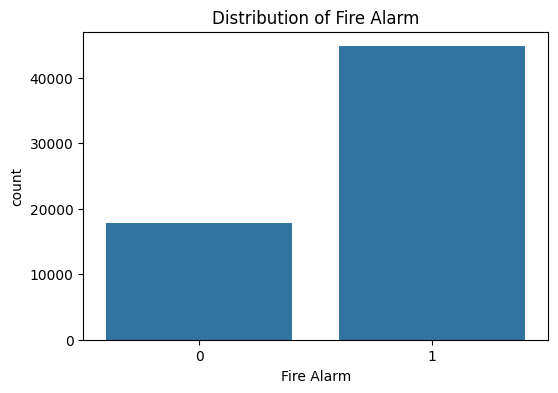

In [4]:

plt.figure(figsize=(6,4))
sns.countplot(x='Fire Alarm', data=data)
plt.title('Distribution of Fire Alarm')
plt.show()

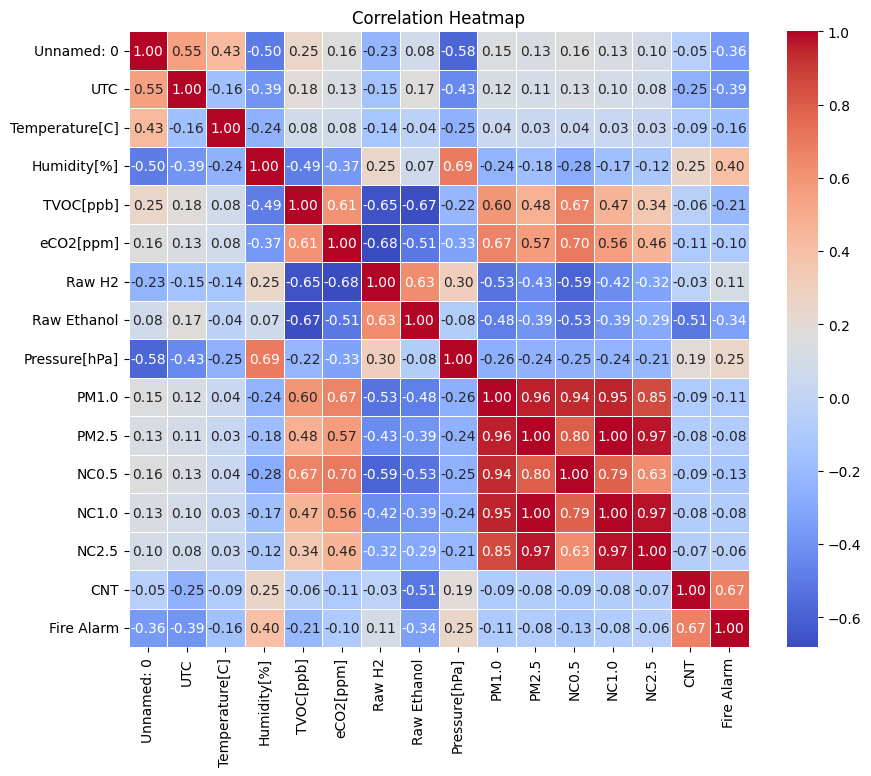

In [5]:

plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

/tmp/ipykernel_20413/3859040617.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  corr.append(data_4[i])
/tmp/ipykernel_20413/3859040617.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr, y=labels, palette='mako')


Text(0.5, 1.0, 'Correlation coefficient between different features and Fire Alarm ')

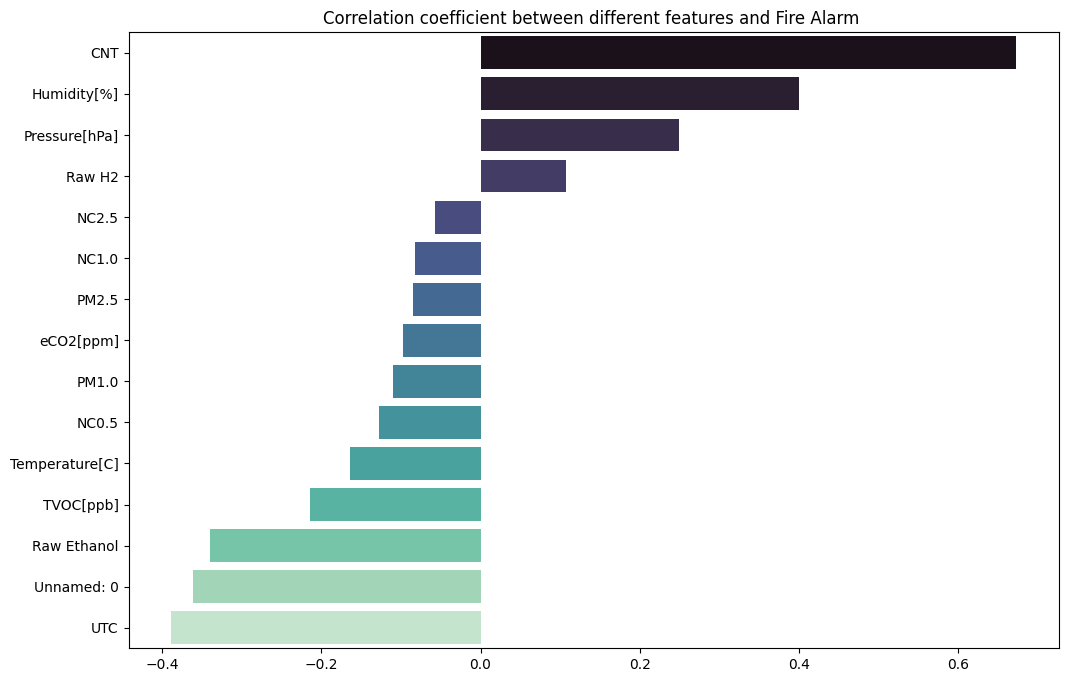

In [6]:
plt.figure(figsize=(12,8))
data_4 = data.corr()["Fire Alarm"].sort_values(ascending=False)
indices = data_4.index
labels = []
corr = []
for i in range(1, len(indices)):
    labels.append(indices[i])
    corr.append(data_4[i])
sns.barplot(x=corr, y=labels, palette='mako')
plt.title('Correlation coefficient between different features and Fire Alarm ')

In [7]:
# Data Cleaning: Drop columns that are unnecessary or have many missing values
data.drop(columns=['Unnamed: 0'], errors='ignore', inplace=True)
data.dropna(inplace=True)

X = data.drop(columns=['Fire Alarm'])
y = data['Fire Alarm']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [8]:
def build_model(input_dim):
    inputs = Input(shape=(input_dim,))

    # First dense layer
    x = Dense(64, activation='relu')(inputs)
    x = BatchNormalization()(x)

    # Residual blocks (10 layers total)
    for _ in range(5):
        shortcut = x
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dense(128, activation=None)(x)
        x = BatchNormalization()(x)

        if shortcut.shape[-1] != x.shape[-1]:
            shortcut = Dense(128, activation=None)(shortcut)

        x = Add()([shortcut, x])
        x = Activation('relu')(x)

    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(2, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

input_dim=X_train.shape[1]
model = build_model(X_train.shape[1])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=1)

Epoch 1/10


E0000 00:00:1746238315.690870   20413 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1746238315.691649   20413 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1253/1253 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9673 - loss: 0.0915 - val_accuracy: 0.9982 - val_loss: 0.0044
Epoch 2/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9963 - loss: 0.0132 - val_accuracy: 0.9996 - val_loss: 0.0011
Epoch 3/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9974 - loss: 0.0100 - val_accuracy: 0.9999 - val_loss: 0.0014
Epoch 4/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9982 - loss: 0.0068 - val_accuracy: 0.9995 - val_loss: 0.0018
Epoch 5/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9981 - loss: 0.0073 - val_accuracy: 0.9999 - val_loss: 8.1098e-04
Epoch 6/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9986 - loss: 0.0065 - val_accuracy: 0.9998 - val_loss: 8.1663e-04
Epoch 7/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9986 - loss: 0.0051 - val_accuracy: 0.9977 - val_loss: 0.0080
Epoch 8/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9985 - loss: 0.0058 - val

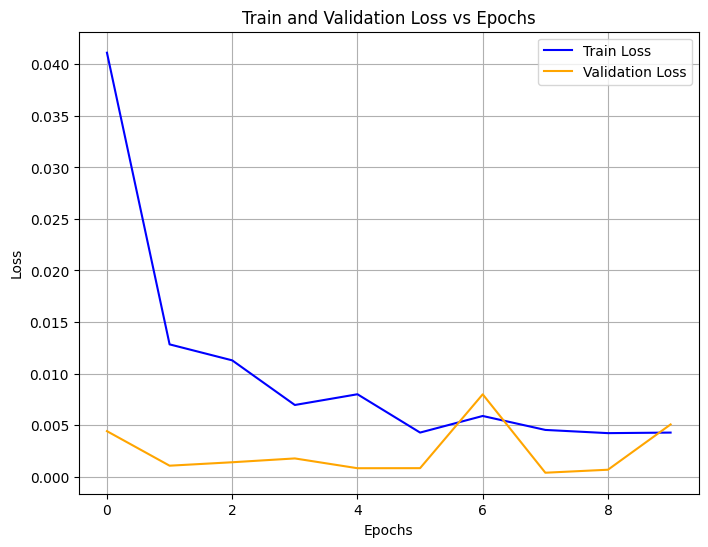

In [9]:
# Plotting Train and Validation Loss vs Epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Train and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 99.93%


In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['No Fire', 'Fire']))


392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Confusion Matrix:
[[3575    0]
 [   9 8942]]

Classification Report:
              precision    recall  f1-score   support

     No Fire       1.00      1.00      1.00      3575
        Fire       1.00      1.00      1.00      8951

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526



In [ ]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


FileNotFoundError: No such file or directory: '<IPython.core.display.Image object>'

FileNotFoundError: No such file or directory: '<IPython.core.display.Image object>'

<IPython.core.display.Image object>

In [18]:
# Measure the original model size
model_size = model.count_params() * 4 / (1024 * 1024)  # Approximate size in MB (4 bytes per parameter)
print(f"Original Model Size: {model_size:.2f} MB")


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = 'smoke_detection_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
    print(f"Model has been converted and saved as {tflite_model_path}")

tflite_model_size = os.path.getsize(tflite_model_path) / (1024 * 1024)  # Size in MB
print(f"TFLite Model Size: {tflite_model_size:.2f} MB")

Original Model Size: 0.69 MB
INFO:tensorflow:Assets written to: /tmp/tmp6vmexqky/assets


INFO:tensorflow:Assets written to: /tmp/tmp6vmexqky/assets


Saved artifact at '/tmp/tmp6vmexqky'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 14), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  137663447509728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137663446533392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137663446538848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137663446543072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137663446540432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137663446541312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137663446547824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137663446544832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137663446540784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137663446540256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137663446545712: Tensor

W0000 00:00:1744768986.386509   12088 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1744768986.386524   12088 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-16 10:03:06.386653: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6vmexqky
2025-04-16 10:03:06.389228: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-16 10:03:06.389238: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp6vmexqky
2025-04-16 10:03:06.406718: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-16 10:03:06.519909: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp6vmexqky
2025-04-16 10:03:06.547503: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 160852 microseconds.


In [ ]:
# teacher_model=model
# # Define the student model (simpler version)
# student_model = tf.keras.models.Sequential([
#     Dense(32, activation='relu', input_shape=(input_dim,)),
#     BatchNormalization(),
#     Dense(64, activation='relu'),
#     BatchNormalization(),
#     Dense(2, activation='sigmoid')
# ])

# student_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Distillation loss function
# def distillation_loss(y_true, y_pred, y_teacher_pred, temperature=5):
#     teacher_probs = tf.nn.softmax(y_teacher_pred / temperature)
#     student_probs = tf.nn.softmax(y_pred / temperature)
#     return tf.keras.losses.KLDivergence()(teacher_probs, student_probs)

# # Train the student model using soft predictions from the teacher
# for epoch in range(5):
#     for x_batch, y_batch in zip(X_train, y_train):
#         x_batch = np.expand_dims(x_batch, axis=0) 
#         y_teacher_pred = teacher_model.predict(x_batch)  # Soft labels from teacher
#         student_model.train_on_batch(x_batch, y_teacher_pred)  # Train with distillation loss

# # Save the distilled model
# distilled_model_path = '/kaggle/working/smoke_detection_model_distilled.h5'
# student_model.save(distilled_model_path)

# print(f"Distilled Model Saved at: {distilled_model_path}")

In [ ]:
# !pip install tensorflow-model-optimization
